# PS4 #12 Hyperparameter tuning

In this problem we illustrate hyperparameter tuning using `GPyTorch` with a simple example.
To get started with GPyTorch, we recommend for example https://docs.gpytorch.ai/en/stable/examples/01_Exact_GPs/Simple_GP_Regression.html

In [2]:
import numpy as np
import gpytorch
import torch
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (14, 8) # Default figsize
np.random.seed(123456)

## Generating data
We start with generating a small data set which will be used for illustrative purposes later on.

**Question** Implement the function $f(x)=-\cos(2\pi x) + \frac12\sin(6\pi x)$. Create a data set with 10 inputs spaced uniformly on the interval $[0.05, 0.95]$, evaluated $f$ at these inputs and add i.i.d. zero-mean Gaussian noise with variance 0.01 to it. Plot $f$ and the data set.

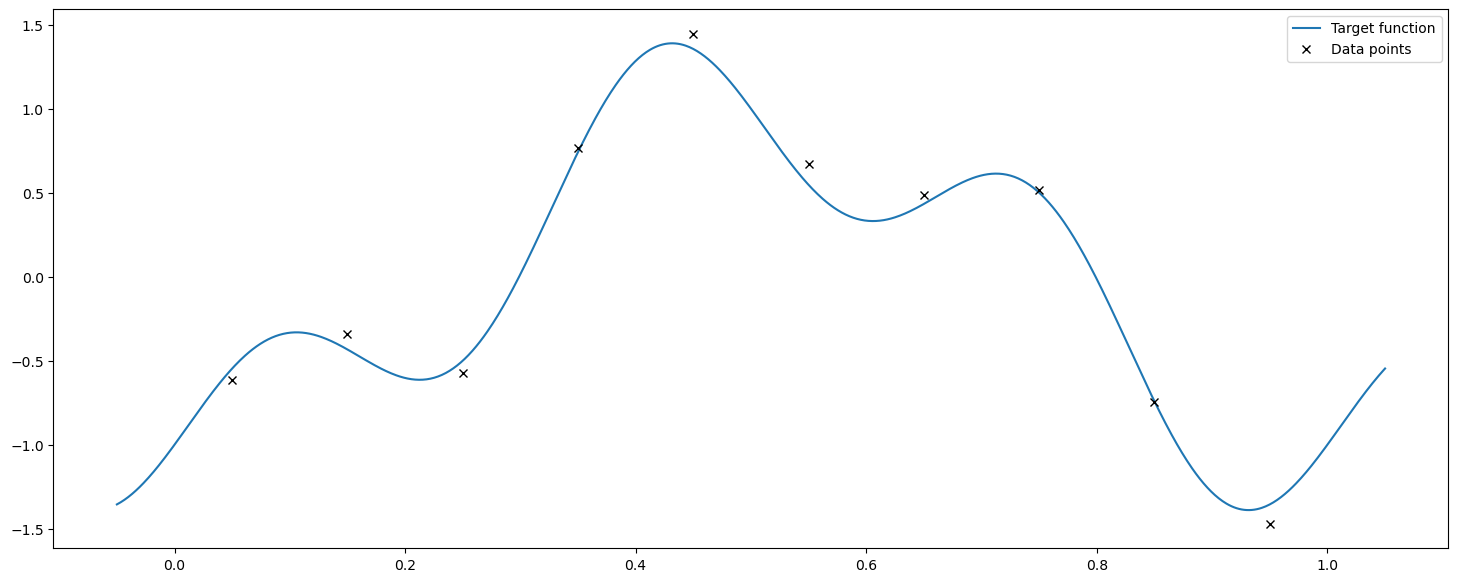

In [3]:
### BEGIN SOLUTION
def f_target(x):
    return -torch.cos(2*np.pi*x) + 0.5*torch.sin(6*np.pi*x)

xs = torch.linspace(-0.05, 1.05, 1000)
ys = f_target(xs)

xs_data = torch.linspace(0.05, 0.95, 10)
ys_data = f_target(xs_data) + torch.randn(xs_data.size())*0.1

plt.figure(figsize=(18, 7))
plt.plot(xs.numpy(), ys.numpy(), label='Target function')
plt.plot(xs_data, ys_data, 'kx', label='Data points')
plt.legend();
### END SOLUTION

## Setup of the GP model
As detailed in the lecture, for GP regression we need a prior GP and a likelihood model.

**Question** Implement a GP regression model using a zero-mean GP with the Squared Exponential kernel as covariance function. For the likelihood, assume additive i.i.d. zero-mean Gaussian noise.

In [4]:
### BEGIN SOLUTION
class ExactGPmodel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPmodel, self).__init__(train_x, train_y, likelihood)
        
        self.mean_module = gpytorch.means.ZeroMean()
        
        se_kernel = gpytorch.kernels.RBFKernel()
        self.covar_module = gpytorch.kernels.ScaleKernel(se_kernel)
        
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPmodel(xs_data, ys_data, likelihood)
### END SOLUTION

## GP regression with manually set hyperparameters
We can now turn to the GP posterior.

**Question** For this question, assume for the hyperparameters $\ell=0.1$ and $\sigma_\mathrm{f}=1$ as well as $\sigma_\mathrm{n}^2=1$. Compute the GP posterior arising from this GP prior and likelihood, using the data set created above.

Plot the posterior mean together with $f$ and the data set. Visualize the 95% confidence interval, i.e., the posterior mean +/- 1.96$\times$ posterior SD.

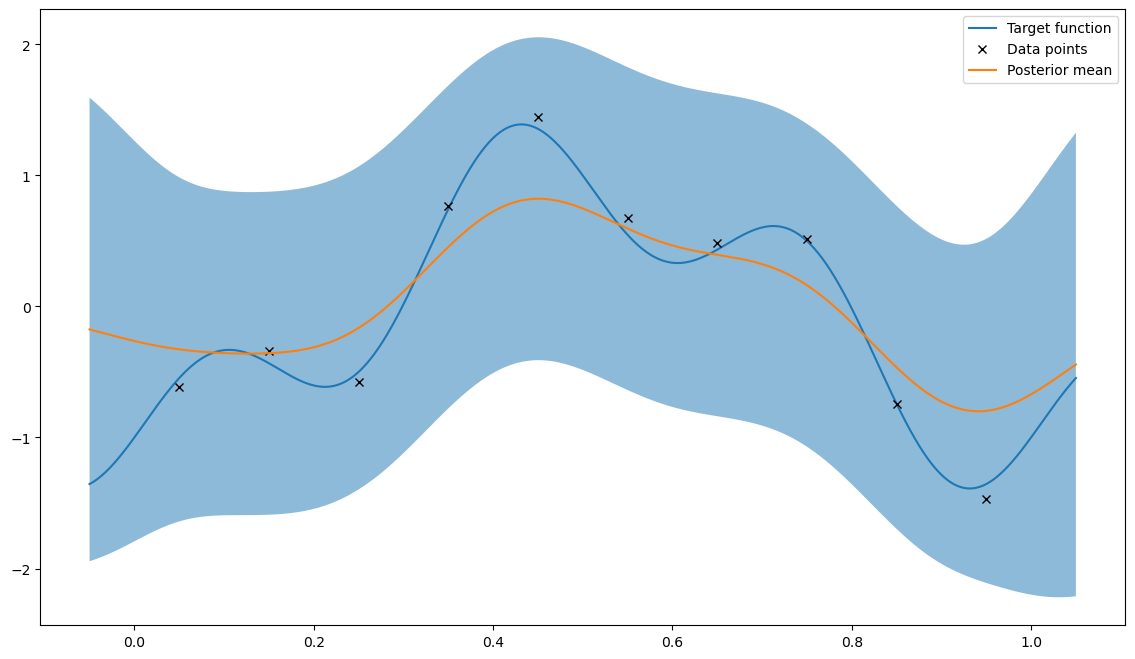

In [5]:
### BEGIN SOLUTION
model.likelihood.noise = 1
model.covar_module.outputscale = 1
model.covar_module.base_kernel.lengthscale = 0.1

with torch.no_grad():
    model.eval()
    f_pred = model(xs)
    lower, upper = f_pred.confidence_region()
    
    plt.figure(figsize=(14, 8))
    plt.plot(xs.numpy(), ys.numpy(), label='Target function')
    plt.plot(xs_data, ys_data, 'kx', label='Data points')
    plt.plot(xs.numpy(), f_pred.mean.numpy(), label='Posterior mean')
    #plt.fill_between(xs.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    plt.fill_between(xs.numpy(),
                     (f_pred.mean - 1.96*f_pred.stddev).numpy(),
                     (f_pred.mean + 1.96*f_pred.stddev).numpy(),
                     alpha=0.5)
    plt.legend();
### END SOLUTION

## Hyperparameter optimization
We now try to find better hyperparameters. We use the second variant outlined in the lecture, applying maximum likelihood approach. This means that we maximize the marginal likelihood of the data given the hyperparameters. Note that this is equivalent to minimizing the negative marginal log-likelihood of the data.

**Question** In the setting of the previous question, perform the maximization of the marginal likelihood w.r.t. $\ell,\sigma_\mathrm{f}$ and $\sigma_\mathrm{n}^2$. You can use for example the Adam optimization algorithm with learning rate 0.1 for 100 steps.

Plot the marginal log-likelihood as well as the hyperparameters during the optimization process.

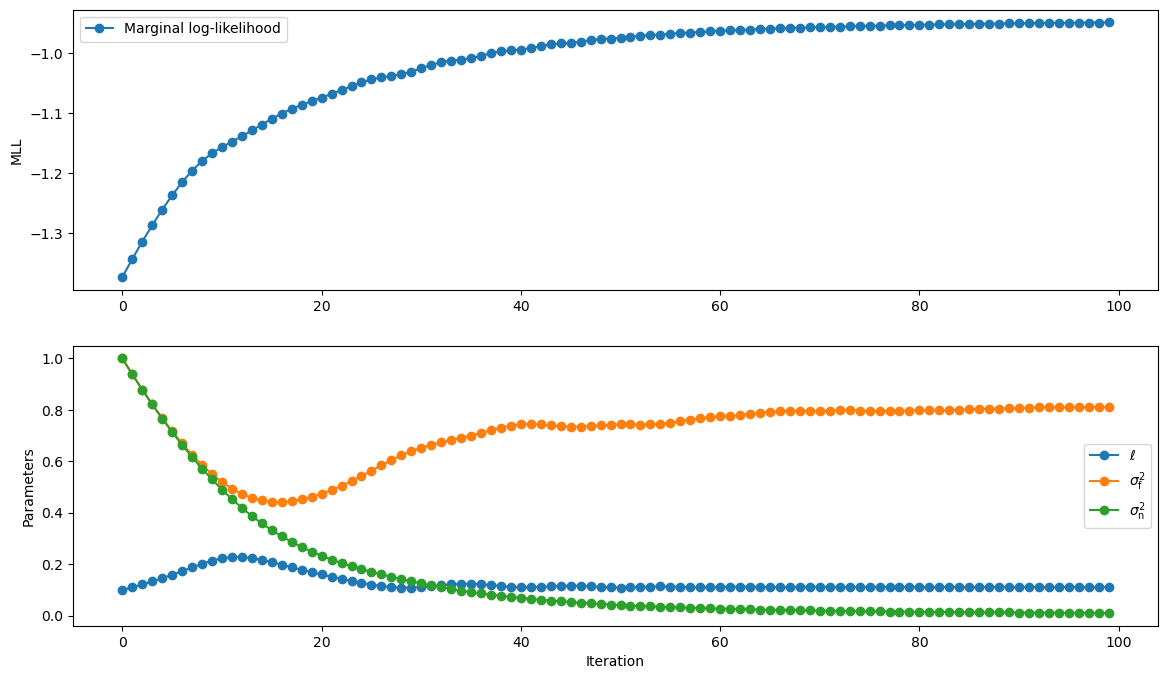

In [6]:
### BEGIN SOLUTION
model.train()
likelihood.train()

optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

n_iter = 100
params = {
    'loss': np.zeros(n_iter),
    'ell': np.zeros(n_iter),
    'sigma2_f': np.zeros(n_iter),
    'sigma2_n': np.zeros(n_iter)
}

for i in range(100):
    optimizer.zero_grad()
    output = model(xs_data)
    loss= -mll(output, ys_data)
    loss.backward()
    
    params['loss'][i] = loss.item()
    params['ell'][i] = model.covar_module.base_kernel.lengthscale.item()
    params['sigma2_f'][i] = model.covar_module.outputscale.item()
    params['sigma2_n'][i] = likelihood.noise.item()
    
    optimizer.step()
    
# Plotting
plt.figure(figsize=(14, 8))
# MLL
plt.subplot(2,1,1)
plt.plot(np.arange(n_iter), -params['loss'], '-o', label='Marginal log-likelihood')
plt.ylabel('MLL')
plt.legend()

plt.subplot(2,1,2)
plt.plot(np.arange(n_iter), params['ell'], '-o', label='$\\ell$')
plt.plot(np.arange(n_iter), params['sigma2_f'], '-o', label='$\\sigma_\\mathrm{f}^2$')
plt.plot(np.arange(n_iter), params['sigma2_n'], '-o', label='$\\sigma_\\mathrm{n}^2$')
plt.xlabel('Iteration')
plt.ylabel('Parameters')
plt.legend();

### END SOLUTION

**Question** Plot the posterior mean together with $f$ and the data set. Visualize the 95% confidence interval, i.e., the posterior mean +/- 1.96$\times$ posterior SD.

Comment on the result. Is it satisfactory learning result? If not, what could be changed?

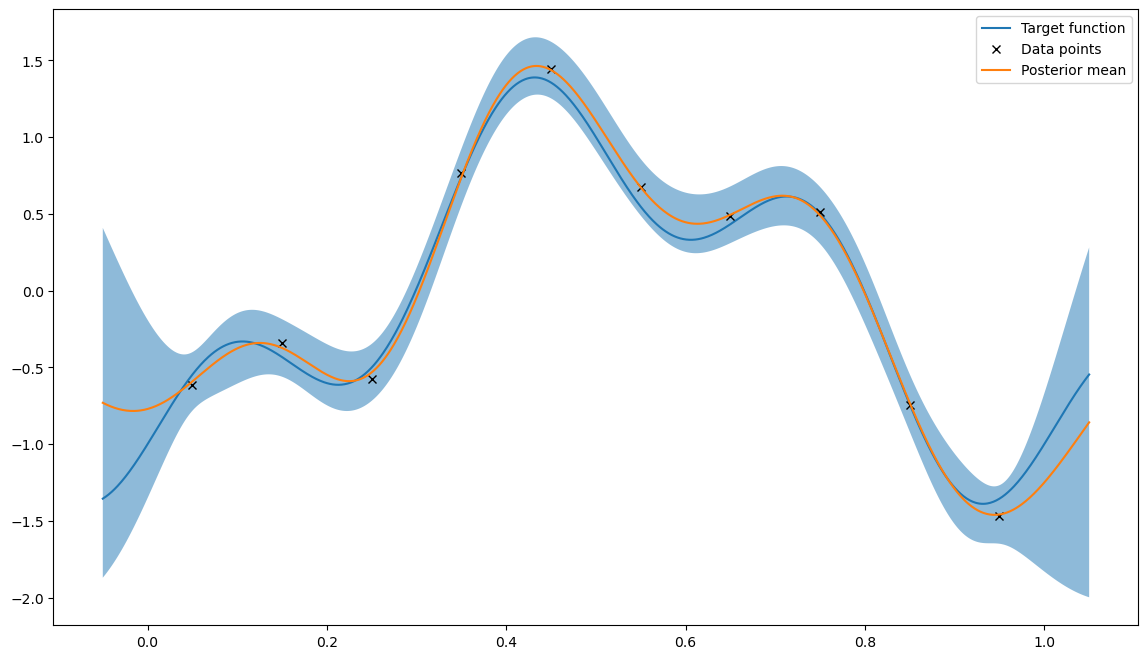

In [7]:
### BEGIN SOLUTION
with torch.no_grad():
    model.eval()
    f_pred = model(xs)
    lower, upper = f_pred.confidence_region()
    
    plt.figure(figsize=(14, 8))
    plt.plot(xs.numpy(), ys.numpy(), label='Target function')
    plt.plot(xs_data, ys_data, 'kx', label='Data points')
    plt.plot(xs.numpy(), f_pred.mean.numpy(), label='Posterior mean')
    #plt.fill_between(xs.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    plt.fill_between(xs.numpy(),
                     (f_pred.mean - 1.96*f_pred.stddev).numpy(),
                     (f_pred.mean + 1.96*f_pred.stddev).numpy(),
                     alpha=0.5)
    plt.legend();
### END SOLUTION

**Question** Repeat the previous question, but this time include a lower bound on the noise variance. Plot again the result. What has changed? Can you explain the change?

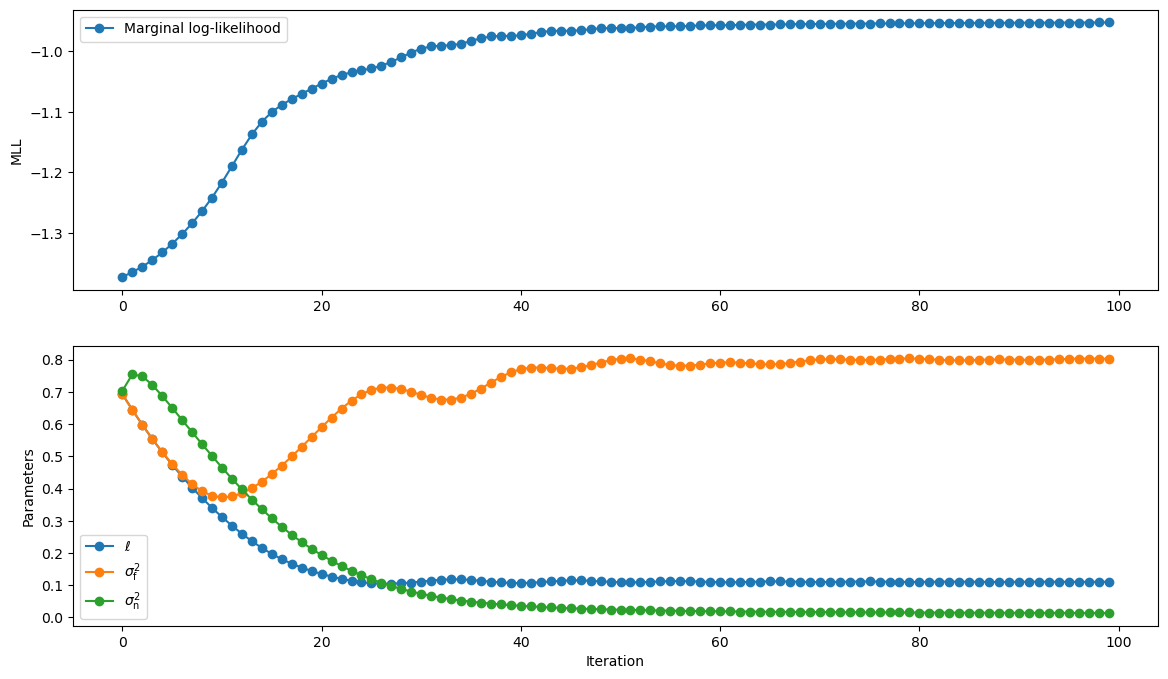

In [16]:
### BEGIN SOLUTION
likelihood = gpytorch.likelihoods.GaussianLikelihood(
    noise_constraint=gpytorch.constraints.GreaterThan(0.01))

model = ExactGPmodel(xs_data, ys_data, likelihood)
# model.mean_module = gpytorch.means.ConstantMean()

model.train()
likelihood.train()

optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

n_iter = 100
params = {
    'loss': np.zeros(n_iter),
    'ell': np.zeros(n_iter),
    'sigma2_f': np.zeros(n_iter),
    'sigma2_n': np.zeros(n_iter),
    'mean': np.zeros(n_iter)
}

for i in range(100):
    optimizer.zero_grad()
    output = model(xs_data)
    loss= -mll(output, ys_data)
    loss.backward()
    
    params['loss'][i] = loss.item()
    params['ell'][i] = model.covar_module.base_kernel.lengthscale.item()
    params['sigma2_f'][i] = model.covar_module.outputscale.item()
    params['sigma2_n'][i] = likelihood.noise.item()
    # params['mean'][i] = model.mean_module.constant.item()
    
    optimizer.step()
    
plt.figure(figsize=(14, 8))
# MLL
plt.subplot(2,1,1)
plt.plot(np.arange(n_iter), -params['loss'], '-o', label='Marginal log-likelihood')
plt.ylabel('MLL')
plt.legend()

plt.subplot(2,1,2)
plt.plot(np.arange(n_iter), params['ell'], '-o', label='$\\ell$')
plt.plot(np.arange(n_iter), params['sigma2_f'], '-o', label='$\\sigma_\\mathrm{f}^2$')
plt.plot(np.arange(n_iter), params['sigma2_n'], '-o', label='$\\sigma_\\mathrm{n}^2$')
# plt.plot(np.arange(n_iter), params['mean'], '-o', label='$m$')
plt.xlabel('Iteration')
plt.ylabel('Parameters')
plt.legend();

### END SOLUTION

**Question** Plot the posterior mean together with $f$ and the data set. Visualize the 95% confidence interval, i.e., the posterior mean +/- 1.96$\times$ posterior SD. Comment on the result.

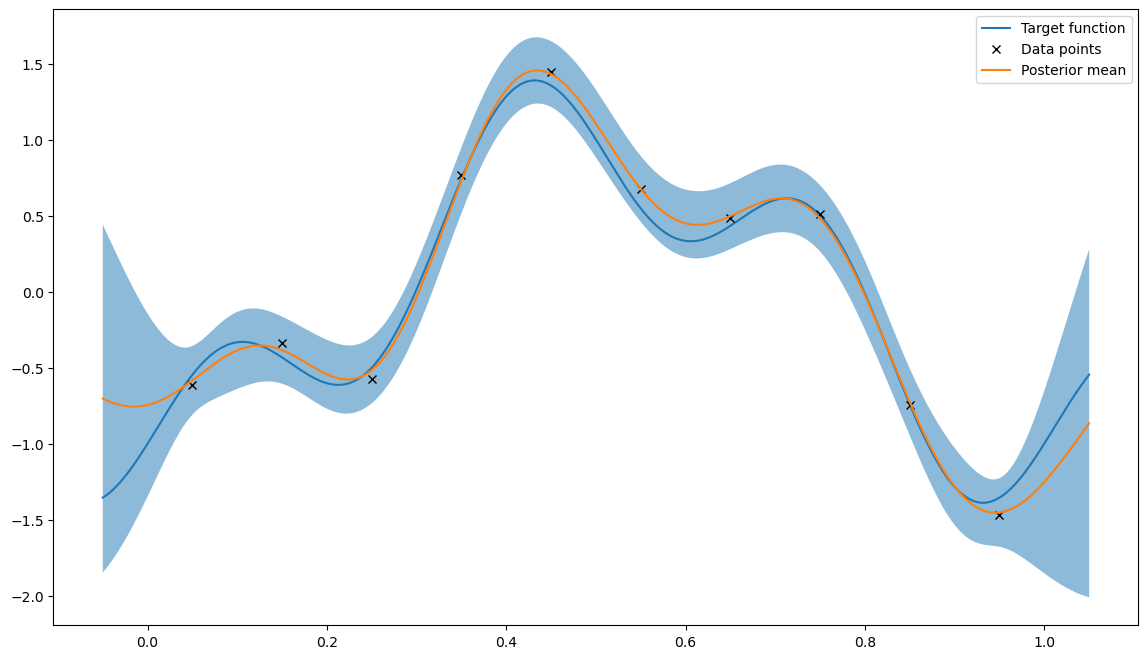

In [17]:
### BEGIN SOLUTION
with torch.no_grad():
    model.eval()
    f_pred = model(xs)
    lower, upper = f_pred.confidence_region()
    
    plt.figure(figsize=(14, 8))
    plt.plot(xs.numpy(), ys.numpy(), label='Target function')
    plt.plot(xs_data, ys_data, 'kx', label='Data points')
    plt.plot(xs.numpy(), f_pred.mean.numpy(), label='Posterior mean')
    #plt.fill_between(xs.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    plt.fill_between(xs.numpy(),
                     (f_pred.mean - 1.96*f_pred.stddev).numpy(),
                     (f_pred.mean + 1.96*f_pred.stddev).numpy(),
                     alpha=0.5)
    plt.legend();
### END SOLUTION

## Hyperparameter optimization: Including the mean
As discussed in the Lecture, in the previous questions we performed hyperparameter optimization on $\ell,\sigma_\mathrm{f}$ and $\sigma_\mathrm{n}^2$, assuming a zero-mean GP prior. However, we can as well assume constant-mean GP prior and treat the constant as a hyperparameter, which in turn can also be optimized.

**Question** Use a GP prior as specified in the previous questions, but this time assume a constant prior mean function, where the offset of this mean function is interpreted as a hyperparameter. Perform again hyperparameter optimization by maximizing the marginal likelihood of the data.

Plot the marginal log-likelihood as well as the hyperparameters  during the optimization process.

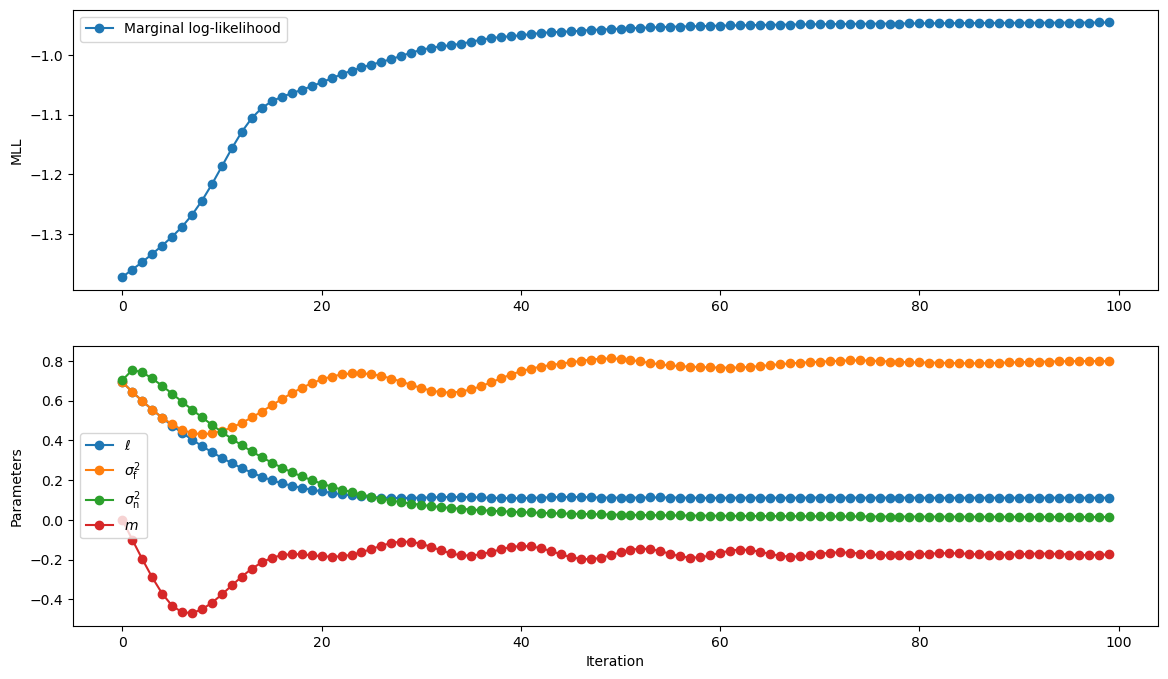

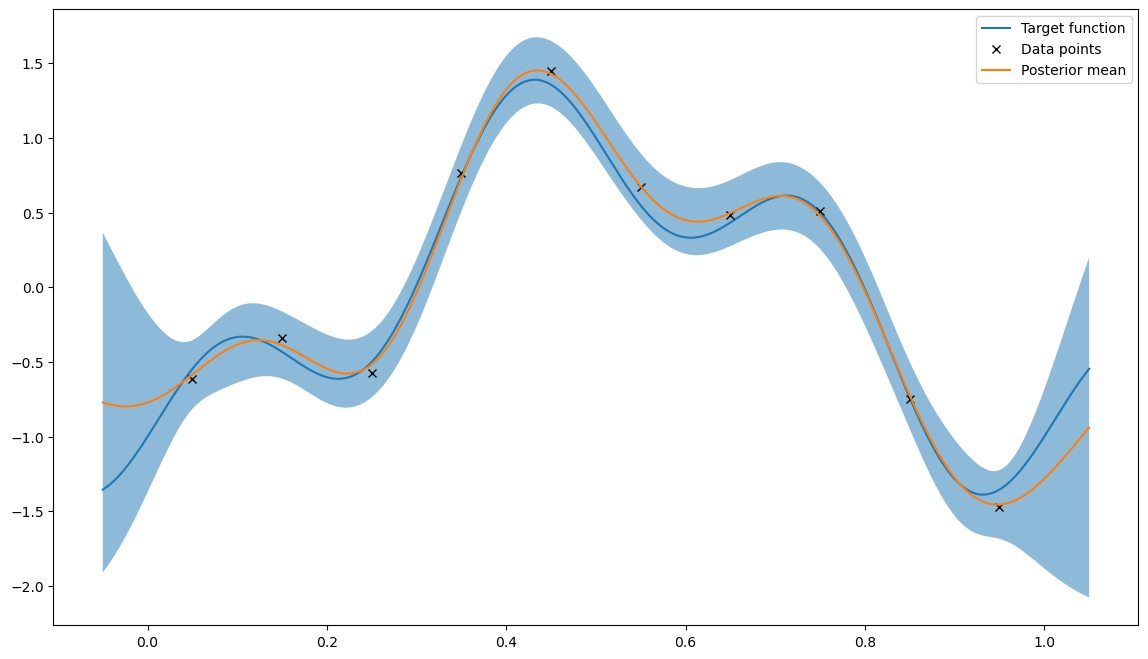

In [18]:
### BEGIN SOLUTION
likelihood = gpytorch.likelihoods.GaussianLikelihood(
    noise_constraint=gpytorch.constraints.GreaterThan(0.01))
model = ExactGPmodel(xs_data, ys_data, likelihood)
model.mean_module = gpytorch.means.ConstantMean()

model.train()
likelihood.train()

optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

n_iter = 100
params = {
    'loss': np.zeros(n_iter),
    'ell': np.zeros(n_iter),
    'sigma2_f': np.zeros(n_iter),
    'sigma2_n': np.zeros(n_iter),
    'mean': np.zeros(n_iter)
}

for i in range(100):
    optimizer.zero_grad()
    output = model(xs_data)
    loss= -mll(output, ys_data)
    loss.backward()
    
    params['loss'][i] = loss.item()
    params['ell'][i] = model.covar_module.base_kernel.lengthscale.item()
    params['sigma2_f'][i] = model.covar_module.outputscale.item()
    params['sigma2_n'][i] = likelihood.noise.item()
    params['mean'][i] = model.mean_module.constant.item()
    
    optimizer.step()
    
plt.figure(figsize=(14, 8))
# MLL
plt.subplot(2,1,1)
plt.plot(np.arange(n_iter), -params['loss'], '-o', label='Marginal log-likelihood')
plt.ylabel('MLL')
plt.legend()

plt.subplot(2,1,2)
plt.plot(np.arange(n_iter), params['ell'], '-o', label='$\\ell$')
plt.plot(np.arange(n_iter), params['sigma2_f'], '-o', label='$\\sigma_\\mathrm{f}^2$')
plt.plot(np.arange(n_iter), params['sigma2_n'], '-o', label='$\\sigma_\\mathrm{n}^2$')
plt.plot(np.arange(n_iter), params['mean'], '-o', label='$m$')
plt.xlabel('Iteration')
plt.ylabel('Parameters')
plt.legend();

with torch.no_grad():
    model.eval()
    f_pred = model(xs)
    lower, upper = f_pred.confidence_region()
    
    plt.figure(figsize=(14, 8))
    plt.plot(xs.numpy(), ys.numpy(), label='Target function')
    plt.plot(xs_data, ys_data, 'kx', label='Data points')
    plt.plot(xs.numpy(), f_pred.mean.numpy(), label='Posterior mean')
    #plt.fill_between(xs.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    plt.fill_between(xs.numpy(),
                     (f_pred.mean - 1.96*f_pred.stddev).numpy(),
                     (f_pred.mean + 1.96*f_pred.stddev).numpy(),
                     alpha=0.5)
    plt.legend();
    
### END SOLUTION

### Reference
This notebook is based on an example from Lab 1 of the Gaussian Process Summer School 2022, cf. https://gpss.cc/gpss22/labs